Aug 1st, 2025


Author: Opal Issan (oissan@ucsd.edu)

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from QLT_equations.general_plasma_equations import Z_prime, I

In [3]:
from scipy.ndimage import gaussian_filter

In [4]:
%matplotlib inline
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [116]:
# normalization 
# time is normalized to the proton cyclotron frequency 1/Omega_cp
# space is normalized to ion inertial length d_i

# cold electron density 
ne = 1 # ne
# cold He+ density
nHe = 0 # ne
# cold O+ density
nO = 0. # ne
# hot proton density 
npH = 0.1 # ne
# cold proton density 
npC = 1 - npH -nO -nHe# ne

# mass ratios
mp_me = 1000 # dimensionless
mO_mp = 16 # dimensionless
mHe_mp = 4 # dimensionless

# driver properties
omega0 = 0.5 / mp_me # Omega_ce
BD_B0 = 2 # dimensionless
k0 = 0.54 * np.sqrt(mp_me) # d_e

omega_pe = 4 # Omega_ce

# assume the plasma is isothermal Te=Tp=TO+=THe+
alpha_c_perp = 0.0079 / 5 # d_e x Omega_ce 0.0007
alpha_c_par = alpha_c_perp # d_e x Omega_ce
alpha_p_par =  alpha_c_perp / np.sqrt(mp_me) # d_e x Omega_ce
alpha_He_par =  alpha_c_perp / np.sqrt(mp_me * mHe_mp)  # de x Omega_ce
alpha_O_par =  alpha_c_perp / np.sqrt(mp_me * mO_mp)  # de x Omega_ce

# # drifts 
# VDp = np.abs(omega0/k0 * BD_B0 * (1 / mp_me/(omega0 + 1/mp_me))) # de x Omega_ce 
# VDe = np.abs(omega0/k0 * BD_B0 * (-1 /(omega0 - 1))) # de x Omega_ce
# VDO = np.abs(omega0/k0 * BD_B0 * (1 / (mO_mp*mp_me) /(omega0 + 1/(mO_mp*mp_me))))
# VDHe = np.abs(omega0/k0 * BD_B0 * (1 /(mHe_mp*mp_me) /(omega0 + 1/(mHe_mp*mp_me))))

# relative drift is what matters
UDp =VDp-VDe
UDO = VDO-VDe
UDHe = VDHe -VDe

omega_pi = omega_pe / np.sqrt(mp_me) # Omega_ce

In [117]:
VDe

5.8589992406728895e-05

In [118]:
VDp

3.904046494035036e-05

In [119]:
UDp/alpha_p_par

-0.3912723669226391

In [120]:
UDO/alpha_O_par

-4.169663098987113

In [121]:
UDHe/alpha_He_par

-1.563916823234245

# dispersion relation 

\begin{align*}
    |\vec{k}|^2  + 2 \frac{\omega_{pe}^2}{\alpha_{\| c}^2}   \left[ 1 -  \Gamma_{0}(\lambda_{c}) \right] 
    = \sum_{s=\{He^{+}, O^{+}, p\}}\frac{\omega_{ps}^2}{\alpha_{\| s}^2}  Z' \left( \frac{\omega - k_{\perp} |\vec{U}_{Ds}|}{\alpha_{\| s} |\vec{k}|}\right)
\end{align*}

In [122]:
def cold_electron_response(k_perp_, omega, omega_pe_, alpha_c_perp_, alpha_c_par_):
    lambda_ =  (k_perp_*alpha_c_perp_/np.sqrt(2))**2
    return 2 * (omega_pe_**2) / (alpha_c_par_**2) * (1 - I(m=0, Lambda=lambda_))

def ion_response(omega_pi_, alpha_i_, k_perp_, v_0_, omega_0_, n_, omega):
    return n_ * (omega_pi_ ** 2) / (alpha_i_ ** 2) *  Z_prime(z=(omega - k_perp * v_0_) / (alpha_i_ * np.abs(k_perp)))

In [123]:
def disp_k(k_perp,
                  npC_=npC,
                  nO_=nO,
                  nHe_=nHe,
                  omega_pe_=omega_pe,
                  omega_pi_=omega_pi,
                  omega_0_=omega0,
                  VDp_=UDp,
                  VDHe_=UDHe,
                  VDO_=UDO,
                  alpha_p_par_=alpha_p_par, 
                  alpha_O_par_=alpha_O_par,
                  alpha_He_par_=alpha_He_par,
                  alpha_c_perp_=alpha_c_perp, 
                 alpha_c_par_=alpha_c_par):
    return lambda omega: k_perp ** 2 \
                         + cold_electron_response(k_perp_=k_perp, omega=omega, omega_pe_=omega_pe, alpha_c_perp_=alpha_c_perp_, alpha_c_par_=alpha_c_par_) \
                         - ion_response(omega_pi_=omega_pi_, n_=npC_, alpha_i_=alpha_p_par_, k_perp_=k_perp, v_0_=VDp_, omega_0_=omega_0_, omega=omega)\
                         - ion_response(omega_pi_=omega_pi_/np.sqrt(mO_mp), n_=nO_, alpha_i_=alpha_O_par_, k_perp_=k_perp, v_0_=VDO_, omega_0_=omega_0_, omega=omega)\
                         - ion_response(omega_pi_=omega_pi_/np.sqrt(mHe_mp), n_=nHe_, alpha_i_=alpha_He_par_, k_perp_=k_perp, v_0_=VDHe_, omega_0_=omega_0_, omega=omega)

In [139]:
k_perp =0.05 / alpha_c_perp *np.sqrt(2) # d_e
omega_guess = 3/mp_me # Omega_ce 


sol_approx = scipy.optimize.newton(disp_k(k_perp=k_perp), omega_guess + 0.05j, tol=1e-11, maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
print(sol_approx)
print("omega_k + i gamma = ", sol_approx)
print("dispersion residual approx = ", abs(disp_k(k_perp=k_perp)(sol_approx)))

RuntimeError: Failed to converge after 10000 iterations, value is (nan+nanj).

In [ ]:
k_perp_ = np.linspace(0.05, 0.12, 60) / alpha_c_perp * np.sqrt(2) # d_e
sol_ = np.zeros(len(k_perp_), dtype="complex128")

In [134]:
for ii in range(len(k_perp_)):
    try:
        sol_[ii] = scipy.optimize.newton(disp_k(k_perp=k_perp_[ii]),  omega_guess + 0.0005j, tol=1e-11, maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
        print("dispersion residual = ", abs(disp_k(k_perp=k_perp_[ii])(sol_[ii])))
    except:
        print("An exception occurred")

An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An excepti

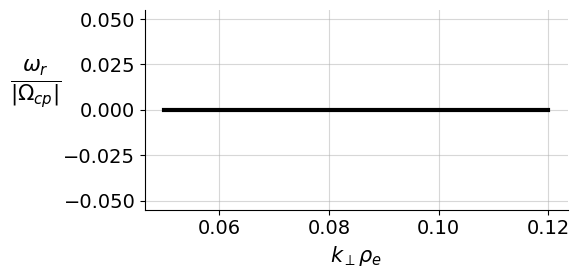

In [135]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_perp_*alpha_c_perp /np.sqrt(2), sol_.real * mp_me, linewidth=3, color="black")
ax.set_ylabel(r'$\frac{\omega_r}{|\Omega_{cp}|}$', fontsize=22, labelpad=20, rotation=0)
ax.set_xlabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
#plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')

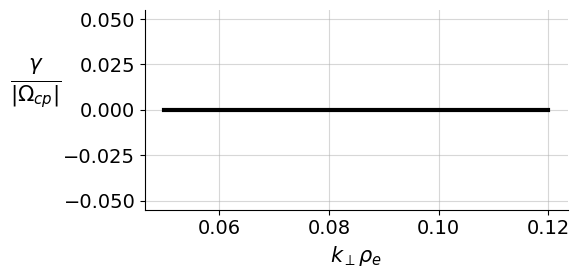

In [136]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_perp_*alpha_c_perp / np.sqrt(2), sol_.imag * mp_me, linewidth=3, color="black")
ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{cp}|}$', fontsize=22, labelpad=20, rotation=0)
ax.set_xlabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
#plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')